In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from missforest import MissForest
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import chi2, SelectPercentile, f_classif, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data = pd.read_csv('../Data/MedIntel_BC_Vault42/JUNO_Protected_BC_Clinical.tsv', sep="\t")

### Drop

In [3]:
data.drop(['Study ID', 'Sample ID'], axis=1, inplace=True)
data.dropna(subset=['Tumor Stage'], inplace=True)
data.dropna(subset=['Relapse Free Status'], inplace=True)

In [4]:
data.columns

Index(['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery',
       'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
       'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
       'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Number of Samples Per Patient', 'Sample Type', 'Sex',
       '3-Gene classifier subtype', 'TMB (nonsynonymous)', 'Tumor Size',
       'Tumor Stage', 'Patient's Vital Status'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1767 entries, 0 to 2505
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      1767 non-null   object 
 1   Age at Diagnosis                1767 non-null   float64
 2   Type of Breast Surgery          1447 non-null   object 
 3   Cancer Type                     1767 non-null   object 
 4   Cancer Type Detailed            1767 non-null   object 
 5   Cellularity                     1409 non-null   object 
 6   Chemotherapy                    1465 non-null   object 
 7   Pam50 + Claudin-low subtype     1465 non-null   object 
 8   Cohort                          1767 non-null   float64
 9   ER status measured by IHC       1713 non-null   object 
 10  ER Status                       1739 non-null   object 
 11  Neoplasm Histologic Grade       1701 non-null   float64
 12  HER2 status measured by SNP6    1465 no

In [6]:
data[['Cellularity', 'Chemotherapy','Overall Survival Status', "Patient's Vital Status"]].head(20)

,Cellularity,Chemotherapy,Overall Survival Status,Patient's Vital Status
0,NaN,NO,0:LIVING,Living
1,High,NO,0:LIVING,Living
2,High,YES,1:DECEASED,Died of Disease
3,Moderate,YES,0:LIVING,Living
4,High,YES,1:DECEASED,Died of Disease
5,Moderate,NO,1:DECEASED,Died of Disease
6,Moderate,YES,0:LIVING,Living
7,High,YES,1:DECEASED,Died of Disease
8,Moderate,NO,1:DECEASED,Died of Other Causes
9,NaN,NaN,NaN,NaN


### Check null values

In [7]:
data['Tumor Stage'].isnull().sum()

0

In [8]:
data['Relapse Free Status'].isnull().sum()

0

In [9]:
data[data[['Tumor Stage', 'Relapse Free Status']].isna().all(axis=1)]

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status


### Unique values

In [10]:
# imblanced data
data['Tumor Stage'].value_counts()

Tumor Stage
2.00    976
1.00    624
3.00    143
0.00     13
4.00     11
Name: count, dtype: int64

In [11]:
data['Relapse Free Status'].value_counts()

Relapse Free Status
0:Not Recurred    1039
1:Recurred         728
Name: count, dtype: int64

In [12]:
data['Radio Therapy'].unique()

array(['YES', 'NO', nan], dtype=object)

In [13]:
data['Number of Samples Per Patient'].unique()

array([1])

In [14]:
data['Sample Type'].unique()

array(['Primary'], dtype=object)

In [15]:
data[data['Tumor Stage'] == 0]

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
42,MB-0110,45.73,BREAST CONSERVING,Breast Cancer,Invasive Breast Carcinoma,Low,NO,claudin-low,1.00,NaN,...,12.33,1:Recurred,1,Primary,Female,NaN,0.00,70.00,0.00,Living
84,MB-0156,60.85,BREAST CONSERVING,Breast Cancer,Invasive Breast Carcinoma,Low,NO,claudin-low,1.00,NaN,...,2.87,0:Not Recurred,1,Primary,Female,NaN,0.00,2.00,0.00,Living
87,MB-0159,51.04,MASTECTOMY,Breast Cancer,Invasive Breast Carcinoma,Low,NO,Basal,1.00,NaN,...,75.30,0:Not Recurred,1,Primary,Female,HER2+,0.00,23.00,0.00,Living
145,MB-0230,41.98,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,Her2,1.00,NaN,...,200.33,0:Not Recurred,1,Primary,Female,HER2+,2.62,35.00,0.00,Living
183,MB-0281,52.79,MASTECTOMY,Breast Cancer,Breast Angiosarcoma,NaN,NO,claudin-low,1.00,NaN,...,72.80,0:Not Recurred,1,Primary,Female,NaN,0.00,NaN,0.00,Living
198,MB-0299,68.83,BREAST CONSERVING,Breast Cancer,Invasive Breast Carcinoma,High,NO,Basal,1.00,NaN,...,188.13,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.00,25.00,0.00,Living
346,MB-0472,59.34,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,NO,LumB,1.00,Positve,...,27.40,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.62,11.00,0.00,Living
389,MB-0522,54.08,NaN,Breast Cancer,Invasive Breast Carcinoma,Low,NO,Her2,1.00,Negative,...,2.50,0:Not Recurred,1,Primary,Female,NaN,9.15,NaN,0.00,Living
403,MB-0539,64.21,MASTECTOMY,Breast Cancer,Invasive Breast Carcinoma,Low,NO,Basal,1.00,NaN,...,85.50,0:Not Recurred,1,Primary,Female,HER2+,0.00,20.00,0.00,Died of Other Causes
425,MB-0573,76.22,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,NO,claudin-low,1.00,Positve,...,163.20,0:Not Recurred,1,Primary,Female,ER+/HER2- Low Prolif,0.00,65.00,0.00,Died of Other Causes


In [16]:
data["Tumor Stage"].unique()

array([2., 1., 4., 3., 0.])

### Replace

In [17]:
data['ER status measured by IHC'].replace({'Positve':'Positive'}, inplace=True)

In [18]:
data['Tumor Stage'].replace({0.0:0, 1.0:1, 2.0:2, 3.0:3, 4.0:4}, inplace=True)

In [19]:
# Relapse Free Status
# 0:Not Recurred
# 1:Recurred

data['Relapse Free Status'].replace({'0:Not Recurred':0, '1:Recurred':1}, inplace=True)

In [20]:
# Overall Survival Status
# 1:DECEASED    822
# 0:LIVING      643

data['Overall Survival Status'].replace({'1:DECEASED':1, '0:LIVING':0}, inplace=True)

### Features type

In [21]:
Cellularity_1 = ['Low', 'Moderate', 'High', np.nan]
Chemotherapy_1 = ['NO', 'YES', np.nan]
ER_status_measured_by_IHC_1 = ['Negative', 'Positive', np.nan]
ER_Status_1 = ['Negative', 'Positive', np.nan]
Neoplasm_Histologic_Grade_1 = [1, 2, 3, np.nan]
HER2_Status_1 = ['Negative', 'Positive', np.nan]
Hormone_Therapy_1 = ['NO', 'YES', np.nan]
Inferred_Menopausal_State_1 = ['Pre', 'Post', np.nan]
Integrative_Cluster_1 = ['1', '2', '3', '4ER-', '4ER+', '5', '6', '7', '8', '9', '10', np.nan]
Primary_Tumor_Laterality_1 = ['Left', 'Right', np.nan]
Overall_Survival_Status_1 = [0, 1, np.nan]
PR_Status = ['Negative', 'Positive', np.nan]
Radio_Therapy_1 = ['NO', 'YES', np.nan]
Relapse_Free_Status_1 = [0, 1]
Tumor_Stage_1 = [0, 1, 2, 3, 4]

In [22]:
numerical_feature = ['Age at Diagnosis',
                     'Lymph nodes examined positive', 
                     'Mutation Count', 
                     'Nottingham prognostic index', 
                     'Overall Survival (Months)',
                     'Relapse Free Status (Months)',
                     'Number of Samples Per Patient', 
                     'TMB (nonsynonymous)', 
                     'Tumor Size']

ordinal_feature = ['Cellularity', 
                   'Chemotherapy', 
                   'ER status measured by IHC', 
                   'ER Status', 
                   'Neoplasm Histologic Grade', 
                   'HER2 Status', 
                   'Hormone Therapy', 
                   'Inferred Menopausal State', 
                   'Integrative Cluster', 
                   'Primary Tumor Laterality', 
                   'Overall Survival Status', 
                   'PR Status', 
                   'Radio Therapy']

nominal_feature = ['Cancer Type', 
                   'Type of Breast Surgery', 
                   'Cancer Type Detailed', 
                   'Pam50 + Claudin-low subtype', 
                   'Cohort', 
                   'HER2 status measured by SNP6', 
                   'Tumor Other Histologic Subtype', 
                   'Oncotree Code', 
                   'Sample Type', 
                   'Sex', 
                   '3-Gene classifier subtype', 
                   "Patient's Vital Status"]


In [23]:
# Chemotherapy, ER status measured by IHC, ER Status, HER2 Status, Hormone Therapy, Primary Tumor Laterality, Overall Survival Status

In [24]:
data['Radio Therapy']

0       YES
1       YES
2        NO
3       YES
4       YES
       ... 
2500    NaN
2502    NaN
2503    NaN
2504    NaN
2505    NaN
Name: Radio Therapy, Length: 1767, dtype: object

In [25]:
ordinal_feature = ['Cellularity', 
                   'Chemotherapy', 
                   'ER status measured by IHC', 
                   'ER Status', 
                   'Neoplasm Histologic Grade', 
                   'HER2 Status', 
                   'Hormone Therapy', 
                   'Inferred Menopausal State', 
                   'Integrative Cluster', 
                   'Primary Tumor Laterality', 
                   'Overall Survival Status', 
                   'PR Status', 
                   'Radio Therapy']

In [26]:
len(numerical_feature) + len(ordinal_feature) + len(nominal_feature)

34

In [27]:
data[[
    'Age at Diagnosis',           # Numerical
    'Tumor Size',                 # Numerical
    'Neoplasm Histologic Grade',  # Ordinal
    'ER Status',                  # Ordinal/Nominal
    'HER2 Status',                # Ordinal/Nominal
    'Tumor Stage',                # Ordinal
    'Overall Survival Status',    # Nominal
    'Cancer Type',                # Nominal
    'Hormone Therapy'             # Ordinal
]].head(10)

,Age at Diagnosis,Tumor Size,Neoplasm Histologic Grade,ER Status,HER2 Status,Tumor Stage,Overall Survival Status,Cancer Type,Hormone Therapy
0,75.65,22.00,3.00,Positive,Negative,2.00,0.00,Breast Cancer,YES
1,43.19,10.00,3.00,Positive,Negative,1.00,0.00,Breast Cancer,YES
2,48.87,15.00,2.00,Positive,Negative,2.00,1.00,Breast Cancer,YES
3,47.68,25.00,2.00,Positive,Negative,2.00,0.00,Breast Cancer,YES
4,76.97,40.00,3.00,Positive,Negative,2.00,1.00,Breast Cancer,YES
5,78.77,31.00,3.00,Positive,Negative,4.00,1.00,Breast Cancer,YES
6,56.45,10.00,2.00,Positive,Negative,2.00,0.00,Breast Cancer,YES
7,70.00,65.00,3.00,Negative,Negative,3.00,1.00,Breast Cancer,NO
8,89.08,29.00,2.00,Positive,Negative,2.00,1.00,Breast Cancer,YES
9,76.24,34.00,3.00,Positive,NaN,2.00,NaN,Breast Cancer,NaN


### Split by column

In [28]:
x = data.drop(['Patient ID', 'Tumor Stage', 'Relapse Free Status'], axis=1)
y_stage = data['Tumor Stage']
y_relapse = data['Relapse Free Status']

In [29]:
x.head()

,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,...,PR Status,Radio Therapy,Relapse Free Status (Months),Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Patient's Vital Status
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,1.00,Positive,Positive,...,Negative,YES,140.50,1,Primary,Female,ER-/HER2-,0.00,22.00,Living
1,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,1.00,Positive,Positive,...,Positive,YES,84.63,1,Primary,Female,ER+/HER2- High Prolif,2.62,10.00,Living
2,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,1.00,Positive,Positive,...,Positive,NO,153.30,1,Primary,Female,NaN,2.62,15.00,Died of Disease
3,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,1.00,Positive,Positive,...,Positive,YES,164.93,1,Primary,Female,NaN,1.31,25.00,Living
4,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,1.00,Positive,Positive,...,Positive,YES,18.80,1,Primary,Female,ER+/HER2- High Prolif,2.62,40.00,Died of Disease


In [30]:
x[['Age at Diagnosis',
                     'Lymph nodes examined positive', 
                     'Mutation Count', 
                     'Nottingham prognostic index', 
                     'Overall Survival (Months)',
                     'Relapse Free Status (Months)',
                     'Number of Samples Per Patient', 
                     'TMB (nonsynonymous)', 
                     'Tumor Size']
  ].head(20)

,Age at Diagnosis,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Relapse Free Status (Months),Number of Samples Per Patient,TMB (nonsynonymous),Tumor Size
0,75.65,10.00,NaN,6.04,140.50,140.50,1,0.00,22.00
1,43.19,0.00,2.00,4.02,84.63,84.63,1,2.62,10.00
2,48.87,1.00,2.00,4.03,163.70,153.30,1,2.62,15.00
3,47.68,3.00,1.00,4.05,164.93,164.93,1,1.31,25.00
4,76.97,8.00,2.00,6.08,41.37,18.80,1,2.62,40.00
5,78.77,0.00,4.00,4.06,7.80,2.93,1,5.23,31.00
6,56.45,1.00,4.00,4.02,164.33,164.33,1,5.23,10.00
7,70.00,NaN,NaN,6.13,22.40,11.90,1,0.00,65.00
8,89.08,1.00,1.00,4.06,99.53,99.53,1,1.31,29.00
9,76.24,11.00,5.00,6.68,NaN,128.00,1,6.54,34.00


### Visualize

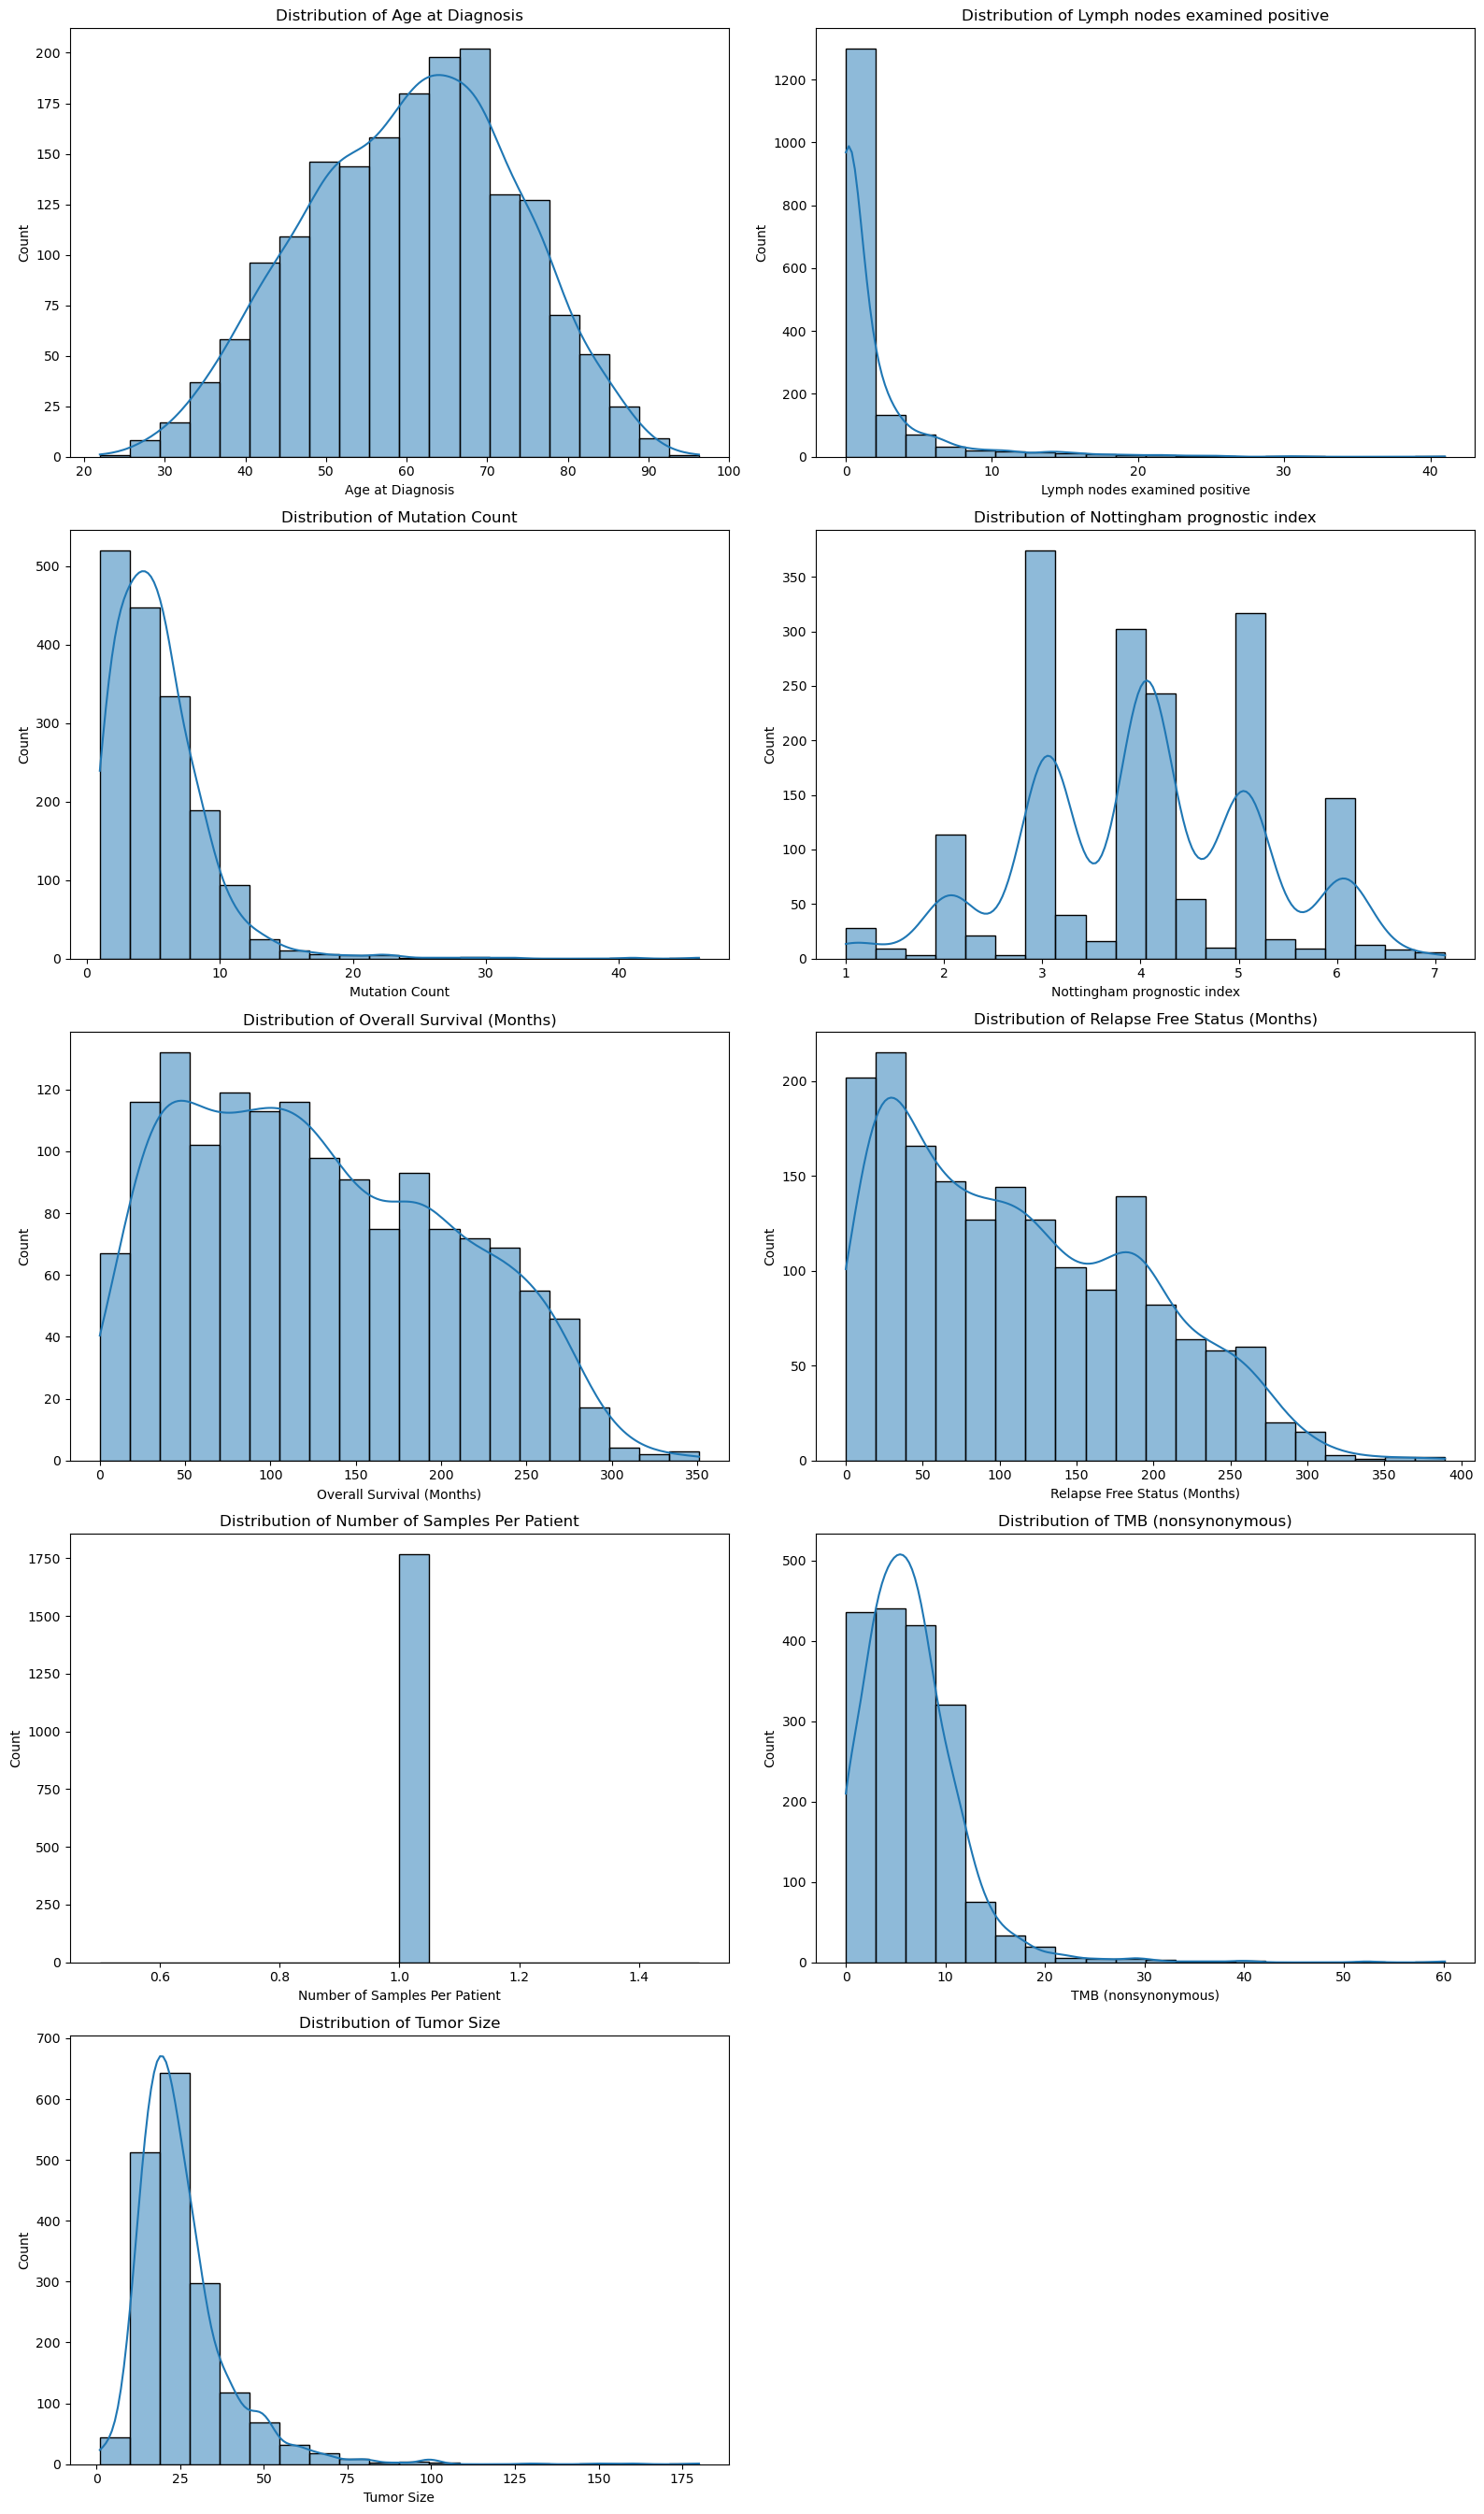

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = [
    'Age at Diagnosis',
    'Lymph nodes examined positive', 
    'Mutation Count', 
    'Nottingham prognostic index', 
    'Overall Survival (Months)',
    'Relapse Free Status (Months)',
    'Number of Samples Per Patient', 
    'TMB (nonsynonymous)', 
    'Tumor Size'
]

plt.figure(figsize=(16, 6 * len(features_to_plot) // 2))

for i, col in enumerate(features_to_plot):
    plt.subplot((len(features_to_plot) + 1) // 2, 2, i + 1)
    sns.histplot(x[col].dropna(), kde=True, bins=20)
    plt.xlabel(col)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


### Split by row

In [32]:
x_train, x_test, y_stage_train, y_stage_test, y_relapse_train, y_relapse_test = train_test_split(
    x, y_stage, y_relapse, test_size=0.2, random_state=42, stratify=y_stage
)

In [33]:
x_train.columns

Index(['Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type',
       'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
       'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
       'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)',
       'Number of Samples Per Patient', 'Sample Type', 'Sex',
       '3-Gene classifier subtype', 'TMB (nonsynonymous)', 'Tumor Size',
       'Patient's Vital Status'],
      dtype='object')

### Check data

In [34]:
x_train[['Cellularity', 'Chemotherapy','Overall Survival Status', "Patient's Vital Status"]].head(20)

,Cellularity,Chemotherapy,Overall Survival Status,Patient's Vital Status
271,High,NO,1.00,Died of Disease
142,NaN,NO,0.00,Living
931,High,NO,1.00,Died of Disease
2479,NaN,NaN,NaN,NaN
500,High,YES,1.00,Died of Disease
508,NaN,NO,1.00,Died of Other Causes
908,High,NO,1.00,Died of Other Causes
2480,NaN,NaN,NaN,NaN
684,High,YES,0.00,Living
748,Moderate,NO,0.00,Living


### MissForest

In [35]:
# mf = MissForest()

# x_train = mf.fit_transform(
#     x=x_train,
#     categorical=numerical_feature + nominal_feature + ordinal_feature
# )

# x_test = mf.transform(x_test)

In [36]:
x_train.isnull().sum().sum()

4432

In [37]:
x_test.isnull().sum().sum()

1195

### ADASYN

In [38]:
# adasyn = ADASYN(
#     sampling_strategy = 'auto',
#     random_state = 42,
#     n_neighbors = 5
# )

# x_train, y_stage_train = adasyn.fit_resample(x_train, y_stage_train)

In [39]:
categorical_indices = [x.columns.get_loc(col) for col in nominal_feature if col in x.columns]

### Preprocessing

In [40]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[
            Cellularity_1,
            Chemotherapy_1,
            ER_status_measured_by_IHC_1,
            ER_Status_1,
            Neoplasm_Histologic_Grade_1,
            HER2_Status_1,
            Hormone_Therapy_1,
            Inferred_Menopausal_State_1,
            Integrative_Cluster_1,
            Primary_Tumor_Laterality_1,
            Overall_Survival_Status_1,
            PR_Status,
            Radio_Therapy_1]))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])


In [41]:
preprocessor = ColumnTransformer(transformers=[
    ('numerical_features', numerical_transformer, numerical_feature),
    ('ordinal_feature', ordinal_transformer, [
            'Cellularity',
            'Chemotherapy',
            'ER status measured by IHC',
            'ER Status',
            'Neoplasm Histologic Grade',
            'HER2 Status',
            'Hormone Therapy',
            'Inferred Menopausal State',
            'Integrative Cluster',
            'Primary Tumor Laterality',
            'Overall Survival Status',
            'PR Status',
            'Radio Therapy'
            ]),
    ('nominal_feature', nominal_transformer, nominal_feature),    
])

### RandomizedSearchCV for Stage

In [42]:
# Stage
clf_stage = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote_nc', SMOTENC(
        categorical_features=categorical_indices,
        sampling_strategy='auto',
        random_state=42)
),
    ('feature_selector', SelectKBest(score_func=f_classif, k=15)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_stage = {
    'classifier__n_estimators': [50, 100, 200, 500],  # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'classifier__class_weight': [None, 'balanced'],  # Class weights for imbalanced classes
    'classifier__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# model_stage = GridSearchCV(
#     estimator=clf_stage,
#     param_grid=param_stage,
#     scoring='f1_weighted',
#     cv=6,
#     verbose=1,
#     n_jobs=1
# )

model_stage = RandomizedSearchCV(
    estimator=clf_stage,
    param_distributions=param_stage,
    n_iter=100,
    scoring='f1_weighted',
    cv=6,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

model_stage.fit(x_train, y_stage_train)
print("Best score for Tumor Stage prediction:", model_stage.best_score_)
print("Best params for Tumor Stage prediction:", model_stage.best_params_)

y_stage_pred = model_stage.predict(x_test)
print(classification_report(y_stage_test, y_stage_pred))

Fitting 6 folds for each of 100 candidates, totalling 600 fits


/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning:

ValueError: could not broadcast input array from shape (9,429) into shape (10,429)

In [ ]:
# Use "median", "mode", RandomizedSearchCV, remove StandardScaler
'''
Best score for Tumor Stage prediction: 0.8845017458791506
Best params for Tumor Stage prediction: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'auto', 'classifier__max_depth': 20, 'classifier__class_weight': None, 'classifier__bootstrap': False}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       0.93      0.92      0.92       125
         2.0       0.86      0.95      0.90       195
         3.0       0.73      0.38      0.50        29
         4.0       0.00      0.00      0.00         2

    accuracy                           0.88       354
   macro avg       0.71      0.52      0.57       354
weighted avg       0.87      0.88      0.87       354
'''

"\nBest score for Tumor Stage prediction: 0.8845017458791506\nBest params for Tumor Stage prediction: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'auto', 'classifier__max_depth': 20, 'classifier__class_weight': None, 'classifier__bootstrap': False}\n              precision    recall  f1-score   support\n\n         0.0       1.00      0.33      0.50         3\n         1.0       0.93      0.92      0.92       125\n         2.0       0.86      0.95      0.90       195\n         3.0       0.73      0.38      0.50        29\n         4.0       0.00      0.00      0.00         2\n\n    accuracy                           0.88       354\n   macro avg       0.71      0.52      0.57       354\nweighted avg       0.87      0.88      0.87       354\n"

In [ ]:
# Fill missing values by MissForest
'''
Best score for Tumor Stage prediction: 0.6302903881664684
Best params for Tumor Stage prediction: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10, 'classifier__class_weight': None, 'classifier__bootstrap': False}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       0.67      0.48      0.56       125
         2.0       0.64      0.87      0.74       195
         3.0       0.00      0.00      0.00        29
         4.0       0.00      0.00      0.00         2

    accuracy                           0.65       354
   macro avg       0.46      0.34      0.36       354
weighted avg       0.60      0.65      0.61       354
'''

"\nBest score for Tumor Stage prediction: 0.6302903881664684\nBest params for Tumor Stage prediction: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10, 'classifier__class_weight': None, 'classifier__bootstrap': False}\n              precision    recall  f1-score   support\n\n         0.0       1.00      0.33      0.50         3\n         1.0       0.67      0.48      0.56       125\n         2.0       0.64      0.87      0.74       195\n         3.0       0.00      0.00      0.00        29\n         4.0       0.00      0.00      0.00         2\n\n    accuracy                           0.65       354\n   macro avg       0.46      0.34      0.36       354\nweighted avg       0.60      0.65      0.61       354\n"

### RandomizedSearchCV for Relapse

In [ ]:
# Relapse
clf_relapse = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('feature_selector', SelectPercentile()),
    ('feature_selector', SelectKBest(score_func=f_classif, k=33)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_relapse = {
    'classifier__n_estimators': [50, 100, 200, 500],  # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'classifier__class_weight': [None, 'balanced'],  # Class weights for imbalanced classes
    'classifier__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
    # 'feature_selector__percentile':[75,80,85,90]

}

# model_relapse = GridSearchCV(
#     estimator=clf_stage,
#     param_grid=param_relapse,
#     scoring='f1',
#     cv=6,
#     verbose=1,
#     n_jobs=1
# )

model_relapse = RandomizedSearchCV(
    estimator=clf_relapse,
    param_distributions=param_relapse,
    n_iter=100,
    scoring='f1',
    cv=6,
    verbose=1,
    n_jobs=1,
    random_state=42
)

model_relapse.fit(x_train, y_relapse_train)
print("Best score for Relapse Free Status prediction:", model_relapse.best_score_)
print("Best params for Relapse Free Status prediction:", model_relapse.best_params_)

y_relapse_pred = model_relapse.predict(x_test)
print(classification_report(y_relapse_test, y_relapse_pred))

Fitting 6 folds for each of 100 candidates, totalling 600 fits
Best score for Relapse Free Status prediction: 0.8096070843308348
Best params for Relapse Free Status prediction: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 20, 'classifier__class_weight': None, 'classifier__bootstrap': True}
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       213
           1       0.99      0.66      0.79       141

    accuracy                           0.86       354
   macro avg       0.90      0.83      0.84       354
weighted avg       0.88      0.86      0.85       354



In [ ]:
# Use "median", "mode", RandomizedSearchCV, remove StandardScaler
'''
Fitting 6 folds for each of 1728 candidates, totalling 10368 fits
Best score for Relapse Free Status prediction: 0.9019655933634428
Best params for Relapse Free Status prediction: {'classifier__bootstrap': False, 'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       213
           1       0.95      0.86      0.90       141

    accuracy                           0.93       354
   macro avg       0.93      0.91      0.92       354
weighted avg       0.93      0.93      0.93       354
'''

"\nFitting 6 folds for each of 1728 candidates, totalling 10368 fits\nBest score for Relapse Free Status prediction: 0.9019655933634428\nBest params for Relapse Free Status prediction: {'classifier__bootstrap': False, 'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}\n              precision    recall  f1-score   support\n\n           0       0.91      0.97      0.94       213\n           1       0.95      0.86      0.90       141\n\n    accuracy                           0.93       354\n   macro avg       0.93      0.91      0.92       354\nweighted avg       0.93      0.93      0.93       354\n"

In [ ]:
# Fill missing values by MissForest
'''
Fitting 6 folds for each of 1728 candidates, totalling 10368 fits
Best score for Relapse Free Status prediction: 0.8098163312262973
Best params for Relapse Free Status prediction: {'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       213
           1       0.85      0.78      0.81       141

    accuracy                           0.86       354
   macro avg       0.86      0.85      0.85       354
weighted avg       0.86      0.86      0.86       354
'''

"\nFitting 6 folds for each of 1728 candidates, totalling 10368 fits\nBest score for Relapse Free Status prediction: 0.8098163312262973\nBest params for Relapse Free Status prediction: {'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}\n              precision    recall  f1-score   support\n\n           0       0.86      0.91      0.89       213\n           1       0.85      0.78      0.81       141\n\n    accuracy                           0.86       354\n   macro avg       0.86      0.85      0.85       354\nweighted avg       0.86      0.86      0.86       354\n"

### Feature importance

In [ ]:
# Stage
result_stage = permutation_importance(model_stage.best_estimator_, x_test, y_stage_test, n_repeats=10, random_state=42)
sorted_idx_stage = result_stage.importances_mean.argsort()[::-1]

print("Feature importance for Tumor Stage:")
for i in sorted_idx_stage:
    print(f"{x.columns[i]}: {result_stage.importances_mean[i]:.3f}")

Feature importance for Tumor Stage:
Cohort: 0.079
Hormone Therapy: 0.058
Patient's Vital Status: 0.055
Radio Therapy: 0.035
Cancer Type Detailed: 0.019
Cellularity: 0.018
Oncotree Code: 0.017
3-Gene classifier subtype: 0.016
Overall Survival Status: 0.014
Cancer Type: 0.000
Chemotherapy: 0.000
Type of Breast Surgery: 0.000
ER status measured by IHC: 0.000
ER Status: 0.000
Neoplasm Histologic Grade: 0.000
HER2 status measured by SNP6: 0.000
HER2 Status: 0.000
Tumor Other Histologic Subtype: 0.000
Integrative Cluster: 0.000
Inferred Menopausal State: 0.000
Tumor Size: 0.000
Primary Tumor Laterality: 0.000
Lymph nodes examined positive: 0.000
Mutation Count: 0.000
Nottingham prognostic index: 0.000
Overall Survival (Months): 0.000
PR Status: 0.000
Relapse Free Status (Months): 0.000
Number of Samples Per Patient: 0.000
Sample Type: 0.000
Sex: 0.000
TMB (nonsynonymous): 0.000
Age at Diagnosis: 0.000
Pam50 + Claudin-low subtype: -0.002


In [ ]:
'''
Feature importance for Tumor Stage:
Tumor Size: 0.212
Nottingham prognostic index: 0.170
Lymph nodes examined positive: 0.126
Cohort: 0.060
Neoplasm Histologic Grade: 0.055
Chemotherapy: 0.026
Hormone Therapy: 0.020
Overall Survival (Months): 0.010
Patient's Vital Status: 0.004
Type of Breast Surgery: 0.003
HER2 Status: 0.000
HER2 status measured by SNP6: 0.000
ER Status: 0.000
ER status measured by IHC: 0.000
Pam50 + Claudin-low subtype: 0.000
Cellularity: 0.000
Cancer Type: 0.000
Tumor Other Histologic Subtype: 0.000
Integrative Cluster: 0.000
Inferred Menopausal State: 0.000
Primary Tumor Laterality: 0.000
Mutation Count: 0.000
Overall Survival Status: 0.000
PR Status: 0.000
...
TMB (nonsynonymous): 0.000
Age at Diagnosis: 0.000
Oncotree Code: -0.000
Cancer Type Detailed: -0.000
'''

"\nFeature importance for Tumor Stage:\nTumor Size: 0.212\nNottingham prognostic index: 0.170\nLymph nodes examined positive: 0.126\nCohort: 0.060\nNeoplasm Histologic Grade: 0.055\nChemotherapy: 0.026\nHormone Therapy: 0.020\nOverall Survival (Months): 0.010\nPatient's Vital Status: 0.004\nType of Breast Surgery: 0.003\nHER2 Status: 0.000\nHER2 status measured by SNP6: 0.000\nER Status: 0.000\nER status measured by IHC: 0.000\nPam50 + Claudin-low subtype: 0.000\nCellularity: 0.000\nCancer Type: 0.000\nTumor Other Histologic Subtype: 0.000\nIntegrative Cluster: 0.000\nInferred Menopausal State: 0.000\nPrimary Tumor Laterality: 0.000\nMutation Count: 0.000\nOverall Survival Status: 0.000\nPR Status: 0.000\n...\nTMB (nonsynonymous): 0.000\nAge at Diagnosis: 0.000\nOncotree Code: -0.000\nCancer Type Detailed: -0.000\n"

In [ ]:
# Relapse
result_relapse = permutation_importance(model_relapse.best_estimator_, x_test, y_relapse_test, n_repeats=10, random_state=42)
sorted_idx_relapse = result_relapse.importances_mean.argsort()[::-1]

print("Feature importance for Relapse Free Status:")
for i in sorted_idx_relapse:
    print(f"{x.columns[i]}: {result_relapse.importances_mean[i]:.3f}")

Feature importance for Relapse Free Status:
Patient's Vital Status: 0.295
Overall Survival Status: 0.019
Integrative Cluster: 0.003
Inferred Menopausal State: 0.001
Pam50 + Claudin-low subtype: 0.001
Type of Breast Surgery: 0.001
Tumor Other Histologic Subtype: 0.000
Primary Tumor Laterality: 0.000
Cancer Type: 0.000
Cancer Type Detailed: 0.000
ER Status: 0.000
HER2 status measured by SNP6: 0.000
Hormone Therapy: 0.000
Sex: 0.000
Tumor Size: 0.000
3-Gene classifier subtype: 0.000
Lymph nodes examined positive: 0.000
PR Status: 0.000
Sample Type: 0.000
Number of Samples Per Patient: 0.000
Relapse Free Status (Months): 0.000
Mutation Count: 0.000
Age at Diagnosis: 0.000
TMB (nonsynonymous): 0.000
Overall Survival (Months): 0.000
Nottingham prognostic index: 0.000
HER2 Status: -0.001
Radio Therapy: -0.001
Cohort: -0.001
Chemotherapy: -0.001
Cellularity: -0.001
ER status measured by IHC: -0.001
Oncotree Code: -0.003
Neoplasm Histologic Grade: -0.003


In [ ]:
'''
Feature importance for Relapse Free Status:
Patient's Vital Status: 0.299
Overall Survival Status: 0.040
Nottingham prognostic index: 0.027
Age at Diagnosis: 0.015
Tumor Size: 0.008
3-Gene classifier subtype: 0.007
Lymph nodes examined positive: 0.007
Neoplasm Histologic Grade: 0.005
Cohort: 0.004
Overall Survival (Months): 0.003
ER status measured by IHC: 0.002
HER2 Status: 0.001
PR Status: 0.001
Chemotherapy: 0.001
Inferred Menopausal State: 0.001
HER2 status measured by SNP6: 0.001
Tumor Other Histologic Subtype: 0.000
Cellularity: 0.000
Cancer Type Detailed: 0.000
ER Status: 0.000
Cancer Type: 0.000
Sex: 0.000
Hormone Therapy: 0.000
Sample Type: 0.000
...
Number of Samples Per Patient: 0.000
Integrative Cluster: 0.000
Type of Breast Surgery: -0.000
Pam50 + Claudin-low subtype: -0.001
'''

"\nFeature importance for Relapse Free Status:\nPatient's Vital Status: 0.299\nOverall Survival Status: 0.040\nNottingham prognostic index: 0.027\nAge at Diagnosis: 0.015\nTumor Size: 0.008\n3-Gene classifier subtype: 0.007\nLymph nodes examined positive: 0.007\nNeoplasm Histologic Grade: 0.005\nCohort: 0.004\nOverall Survival (Months): 0.003\nER status measured by IHC: 0.002\nHER2 Status: 0.001\nPR Status: 0.001\nChemotherapy: 0.001\nInferred Menopausal State: 0.001\nHER2 status measured by SNP6: 0.001\nTumor Other Histologic Subtype: 0.000\nCellularity: 0.000\nCancer Type Detailed: 0.000\nER Status: 0.000\nCancer Type: 0.000\nSex: 0.000\nHormone Therapy: 0.000\nSample Type: 0.000\n...\nNumber of Samples Per Patient: 0.000\nIntegrative Cluster: 0.000\nType of Breast Surgery: -0.000\nPam50 + Claudin-low subtype: -0.001\n"

### Lazy Prediction

In [ ]:
clf_stage = LazyClassifier(verbose=2, ignore_warnings=True, custom_metric=None)
models_stage, predictions_stage = clf_stage.fit(x_train, x_test, y_stage_train, y_stage_test)
models_stage

  7%|▋         | 2/29 [00:00<00:04,  5.97it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.4632768361581921, 'Balanced Accuracy': 0.35767285587975245, 'ROC AUC': None, 'F1 Score': 0.45237102898953413, 'Time taken': 0.23467707633972168}
{'Model': 'BaggingClassifier', 'Accuracy': 0.8389830508474576, 'Balanced Accuracy': 0.4176339522546419, 'ROC AUC': None, 'F1 Score': 0.8287520290196472, 'Time taken': 0.1199347972869873}
{'Model': 'BernoulliNB', 'Accuracy': 0.652542372881356, 'Balanced Accuracy': 0.5881740053050397, 'ROC AUC': None, 'F1 Score': 0.6611408588122717, 'Time taken': 0.026547908782958984}


 14%|█▍        | 4/29 [00:01<00:12,  2.00it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7401129943502824, 'Balanced Accuracy': 0.339746065428824, 'ROC AUC': None, 'F1 Score': 0.7136395110610888, 'Time taken': 1.3710739612579346}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.827683615819209, 'Balanced Accuracy': 0.41767922192749773, 'ROC AUC': None, 'F1 Score': 0.8219972238811024, 'Time taken': 0.03786015510559082}
{'Model': 'DummyClassifier', 'Accuracy': 0.5508474576271186, 'Balanced Accuracy': 0.2, 'ROC AUC': None, 'F1 Score': 0.3913124015930351, 'Time taken': 0.020960092544555664}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.5903954802259888, 'Balanced Accuracy': 0.3015313881520778, 'ROC AUC': None, 'F1 Score': 0.5966586771671519, 'Time taken': 0.02179098129272461}


 41%|████▏     | 12/29 [00:02<00:02,  6.95it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.731638418079096, 'Balanced Accuracy': 0.35268611847922193, 'ROC AUC': None, 'F1 Score': 0.7117327613092239, 'Time taken': 0.2522718906402588}
{'Model': 'GaussianNB', 'Accuracy': 0.1016949152542373, 'Balanced Accuracy': 0.36235048629531386, 'ROC AUC': None, 'F1 Score': 0.05448169135178577, 'Time taken': 0.024995088577270508}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.6779661016949152, 'Balanced Accuracy': 0.3935434129089302, 'ROC AUC': None, 'F1 Score': 0.663132143783563, 'Time taken': 0.02929830551147461}
{'Model': 'LabelPropagation', 'Accuracy': 0.655367231638418, 'Balanced Accuracy': 0.3391603890362511, 'ROC AUC': None, 'F1 Score': 0.6445995716341552, 'Time taken': 0.07914495468139648}


 48%|████▊     | 14/29 [00:02<00:02,  7.48it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.655367231638418, 'Balanced Accuracy': 0.3391603890362511, 'ROC AUC': None, 'F1 Score': 0.6445995716341552, 'Time taken': 0.12671113014221191}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.7203389830508474, 'Balanced Accuracy': 0.44460053050397874, 'ROC AUC': None, 'F1 Score': 0.7171785653141585, 'Time taken': 0.07845592498779297}


 55%|█████▌    | 16/29 [00:02<00:02,  5.84it/s]

{'Model': 'LinearSVC', 'Accuracy': 0.731638418079096, 'Balanced Accuracy': 0.40932979664014146, 'ROC AUC': None, 'F1 Score': 0.7128310449829357, 'Time taken': 0.417647123336792}
{'Model': 'LogisticRegression', 'Accuracy': 0.7853107344632768, 'Balanced Accuracy': 0.45861856763925735, 'ROC AUC': None, 'F1 Score': 0.7742781809404361, 'Time taken': 0.12403488159179688}
{'Model': 'NearestCentroid', 'Accuracy': 0.5790960451977402, 'Balanced Accuracy': 0.6476328912466843, 'ROC AUC': None, 'F1 Score': 0.598129380610283, 'Time taken': 0.05509829521179199}


 72%|███████▏  | 21/29 [00:03<00:00,  9.14it/s]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.6666666666666666, 'Balanced Accuracy': 0.4321329796640141, 'ROC AUC': None, 'F1 Score': 0.6683951815699066, 'Time taken': 0.06503701210021973}
{'Model': 'Perceptron', 'Accuracy': 0.6440677966101694, 'Balanced Accuracy': 0.3323529619805482, 'ROC AUC': None, 'F1 Score': 0.5976085332280233, 'Time taken': 0.07606291770935059}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.12429378531073447, 'Balanced Accuracy': 0.21997948717948718, 'ROC AUC': None, 'F1 Score': 0.09241144304819163, 'Time taken': 0.05228686332702637}


 86%|████████▌ | 25/29 [00:03<00:00,  9.05it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.844632768361582, 'Balanced Accuracy': 0.3969032714412025, 'ROC AUC': None, 'F1 Score': 0.8189822055354484, 'Time taken': 0.2880833148956299}
{'Model': 'RidgeClassifier', 'Accuracy': 0.6864406779661016, 'Balanced Accuracy': 0.3097931034482758, 'ROC AUC': None, 'F1 Score': 0.6586647855822313, 'Time taken': 0.03668713569641113}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.6949152542372882, 'Balanced Accuracy': 0.3134443854995579, 'ROC AUC': None, 'F1 Score': 0.6666861566617848, 'Time taken': 0.046095848083496094}
{'Model': 'SGDClassifier', 'Accuracy': 0.7146892655367232, 'Balanced Accuracy': 0.3750974358974359, 'ROC AUC': None, 'F1 Score': 0.6807290573912255, 'Time taken': 0.1051938533782959}


 93%|█████████▎| 27/29 [00:03<00:00,  8.75it/s]

{'Model': 'SVC', 'Accuracy': 0.7824858757062146, 'Balanced Accuracy': 0.4371083996463307, 'ROC AUC': None, 'F1 Score': 0.7619430812314794, 'Time taken': 0.2468259334564209}
{'Model': 'XGBClassifier', 'Accuracy': 0.8587570621468926, 'Balanced Accuracy': 0.5186603006189212, 'ROC AUC': None, 'F1 Score': 0.8534193011259618, 'Time taken': 0.3031880855560303}


100%|██████████| 29/29 [00:05<00:00,  5.77it/s]

{'Model': 'LGBMClassifier', 'Accuracy': 0.8700564971751412, 'Balanced Accuracy': 0.5186150309460654, 'ROC AUC': None, 'F1 Score': 0.8612237917319644, 'Time taken': 0.7372889518737793}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.58,0.65,None,0.60,0.06
BernoulliNB,0.65,0.59,None,0.66,0.03
XGBClassifier,0.86,0.52,None,0.85,0.30
LGBMClassifier,0.87,0.52,None,0.86,0.74
LogisticRegression,0.79,0.46,None,0.77,0.12
LinearDiscriminantAnalysis,0.72,0.44,None,0.72,0.08
SVC,0.78,0.44,None,0.76,0.25
PassiveAggressiveClassifier,0.67,0.43,None,0.67,0.07
DecisionTreeClassifier,0.83,0.42,None,0.82,0.04


In [ ]:
clf_relapse = LazyClassifier(verbose=2, ignore_warnings=True, custom_metric=None)
models_relapse, predictions_relapse = clf_relapse.fit(x_train, x_test, y_relapse_train, y_relapse_test)
models_relapse

 10%|█         | 3/29 [00:00<00:03,  8.32it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.9124293785310734, 'Balanced Accuracy': 0.9056537808410748, 'ROC AUC': 0.9056537808410748, 'F1 Score': 0.9121469802023984, 'Time taken': 0.2893979549407959}
{'Model': 'BaggingClassifier', 'Accuracy': 0.9322033898305084, 'Balanced Accuracy': 0.9256817500749175, 'ROC AUC': 0.9256817500749176, 'F1 Score': 0.9319372799475968, 'Time taken': 0.09914922714233398}
{'Model': 'BernoulliNB', 'Accuracy': 0.8305084745762712, 'Balanced Accuracy': 0.8064129457596644, 'ROC AUC': 0.8064129457596644, 'F1 Score': 0.8263930329100111, 'Time taken': 0.02234506607055664}


 28%|██▊       | 8/29 [00:00<00:02, 10.20it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.8983050847457628, 'Balanced Accuracy': 0.8927180101887924, 'ROC AUC': 0.8927180101887924, 'F1 Score': 0.8981794935620375, 'Time taken': 0.402785062789917}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.8954802259887006, 'Balanced Accuracy': 0.8939666366996304, 'ROC AUC': 0.8939666366996303, 'F1 Score': 0.8957700132406706, 'Time taken': 0.0495905876159668}
{'Model': 'DummyClassifier', 'Accuracy': 0.6016949152542372, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.45206707918572325, 'Time taken': 0.024036169052124023}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.7768361581920904, 'Balanced Accuracy': 0.7558185995405055, 'ROC AUC': 0.7558185995405053, 'F1 Score': 0.7735392787757972, 'Time taken': 0.032048940658569336}


 41%|████▏     | 12/29 [00:01<00:01, 10.83it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.8898305084745762, 'Balanced Accuracy': 0.862900809109979, 'ROC AUC': 0.862900809109979, 'F1 Score': 0.8859136084056203, 'Time taken': 0.23529601097106934}
{'Model': 'GaussianNB', 'Accuracy': 0.4152542372881356, 'Balanced Accuracy': 0.5128858255918489, 'ROC AUC': 0.512885825591849, 'F1 Score': 0.2671213968267367, 'Time taken': 0.0221097469329834}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.864406779661017, 'Balanced Accuracy': 0.8525621816002398, 'ROC AUC': 0.8525621816002398, 'F1 Score': 0.8634692253514685, 'Time taken': 0.03201794624328613}
{'Model': 'LabelPropagation', 'Accuracy': 0.8135593220338984, 'Balanced Accuracy': 0.7947258016182199, 'ROC AUC': 0.79472580161822, 'F1 Score': 0.8109825927622538, 'Time taken': 0.08457803726196289}


 48%|████▊     | 14/29 [00:01<00:01, 11.33it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.8135593220338984, 'Balanced Accuracy': 0.7947258016182199, 'ROC AUC': 0.79472580161822, 'F1 Score': 0.8109825927622538, 'Time taken': 0.11659002304077148}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.8926553672316384, 'Balanced Accuracy': 0.8844271301568275, 'ROC AUC': 0.8844271301568276, 'F1 Score': 0.892234026583695, 'Time taken': 0.04165196418762207}
{'Model': 'LinearSVC', 'Accuracy': 0.9011299435028248, 'Balanced Accuracy': 0.8962641094795725, 'ROC AUC': 0.8962641094795725, 'F1 Score': 0.9010697910352717, 'Time taken': 0.13805699348449707}


 55%|█████▌    | 16/29 [00:01<00:01, 10.95it/s]

{'Model': 'LogisticRegression', 'Accuracy': 0.8983050847457628, 'Balanced Accuracy': 0.8927180101887924, 'ROC AUC': 0.8927180101887924, 'F1 Score': 0.8981794935620375, 'Time taken': 0.05741405487060547}
{'Model': 'NearestCentroid', 'Accuracy': 0.807909604519774, 'Balanced Accuracy': 0.8032164618919189, 'ROC AUC': 0.8032164618919189, 'F1 Score': 0.8085384718859295, 'Time taken': 0.04754304885864258}


 72%|███████▏  | 21/29 [00:02<00:00, 12.61it/s]

{'Model': 'NuSVC', 'Accuracy': 0.9124293785310734, 'Balanced Accuracy': 0.8984616921386475, 'ROC AUC': 0.8984616921386475, 'F1 Score': 0.9113007584852241, 'Time taken': 0.24305200576782227}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.8757062146892656, 'Balanced Accuracy': 0.8571571271601239, 'ROC AUC': 0.8571571271601239, 'F1 Score': 0.8734994878003353, 'Time taken': 0.02935791015625}
{'Model': 'Perceptron', 'Accuracy': 0.9067796610169492, 'Balanced Accuracy': 0.9021576266107283, 'ROC AUC': 0.9021576266107283, 'F1 Score': 0.9067229458332563, 'Time taken': 0.027103185653686523}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.4915254237288136, 'Balanced Accuracy': 0.5750674258315852, 'ROC AUC': 0.5750674258315852, 'F1 Score': 0.41024054474132193, 'Time taken': 0.049700021743774414}


 79%|███████▉  | 23/29 [00:02<00:00,  9.81it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9124293785310734, 'Balanced Accuracy': 0.8948656477874337, 'ROC AUC': 0.8948656477874338, 'F1 Score': 0.9107840077980881, 'Time taken': 0.2948429584503174}
{'Model': 'RidgeClassifier', 'Accuracy': 0.8926553672316384, 'Balanced Accuracy': 0.8844271301568275, 'ROC AUC': 0.8844271301568276, 'F1 Score': 0.892234026583695, 'Time taken': 0.02753925323486328}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.8898305084745762, 'Balanced Accuracy': 0.8820797123164519, 'ROC AUC': 0.8820797123164519, 'F1 Score': 0.8894752331578558, 'Time taken': 0.053015947341918945}
{'Model': 'SGDClassifier', 'Accuracy': 0.8728813559322034, 'Balanced Accuracy': 0.882379382679053, 'ROC AUC': 0.882379382679053, 'F1 Score': 0.8740946452397136, 'Time taken': 0.04469609260559082}


 97%|█████████▋| 28/29 [00:02<00:00, 10.81it/s]

{'Model': 'SVC', 'Accuracy': 0.9124293785310734, 'Balanced Accuracy': 0.9044550993906703, 'ROC AUC': 0.9044550993906704, 'F1 Score': 0.9120226890188139, 'Time taken': 0.17919206619262695}
{'Model': 'XGBClassifier', 'Accuracy': 0.9322033898305084, 'Balanced Accuracy': 0.9316751573269404, 'ROC AUC': 0.9316751573269403, 'F1 Score': 0.9323561810508553, 'Time taken': 0.15012407302856445}


100%|██████████| 29/29 [00:02<00:00,  9.83it/s]

{'Model': 'LGBMClassifier', 'Accuracy': 0.9293785310734464, 'Balanced Accuracy': 0.9257316951353511, 'ROC AUC': 0.9257316951353511, 'F1 Score': 0.9293355650251941, 'Time taken': 0.1267547607421875}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.93,0.93,0.93,0.93,0.15
LGBMClassifier,0.93,0.93,0.93,0.93,0.13
BaggingClassifier,0.93,0.93,0.93,0.93,0.10
AdaBoostClassifier,0.91,0.91,0.91,0.91,0.29
SVC,0.91,0.90,0.90,0.91,0.18
Perceptron,0.91,0.90,0.90,0.91,0.03
NuSVC,0.91,0.90,0.90,0.91,0.24
LinearSVC,0.90,0.90,0.90,0.90,0.14
RandomForestClassifier,0.91,0.89,0.89,0.91,0.29
